# Mechanisms of Action (MoA) Prediction

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

train_features.csv - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

train_drug.csv - This file contains an anonymous drug_id for the training set only.

train_targets_scored.csv - The binary MoA targets that are scored.

train_targets_nonscored.csv - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.

test_features.csv - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

sample_submission.csv - A submission file in the correct format.

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import os
import time
import plotly.express as px
import random
from sklearn.metrics import log_loss

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
!kaggle competitions download -c lish-moa

100% 64.7M/64.7M [00:02<00:00, 36.9MB/s]
100% 64.7M/64.7M [00:02<00:00, 25.9MB/s]


In [5]:
!unzip "/content/lish-moa.zip"

Archive:  /content/lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


train_features.csv - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

In [6]:
train_features=pd.read_csv("/content/train_features.csv")
train_features	

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [7]:
train_targets_scored=pd.read_csv("/content/train_targets_scored.csv")
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_features=pd.read_csv("/content/test_features.csv")
test_features

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3977,id_ff7004b87,trt_cp,24,D1,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-1.1790,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600
3978,id_ff925dd0d,trt_cp,24,D1,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.0210,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934
3979,id_ffb710450,trt_cp,72,D1,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.4418,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504
3980,id_ffbb869f2,trt_cp,48,D2,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,0.3079,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484


In [9]:
sample_submission=pd.read_csv("/content/sample_submission.csv")

In [10]:
#extract genes column names
genes=[col for col in train_features.columns if col.startswith("g")]

In [11]:
##extract cell column names
cells=[col for col in train_features.columns if col.startswith("c")]
for item in ['cp_dose','cp_time','cp_type']:
  cells.remove(item)

In [12]:
genes_train=train_features[genes]
test_genes=test_features[genes]

In [13]:
#combine genes data in test and train:
genes_data=pd.concat([genes_train,test_genes])

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
pca_x=pca.fit_transform(genes_data)

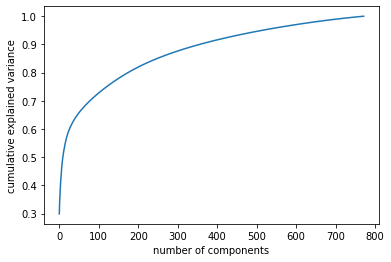

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

according to above visulization, the optimum value of components to explain variance is about 100

In [16]:
cell_data=pd.concat([train_features[cells],test_features[cells]])

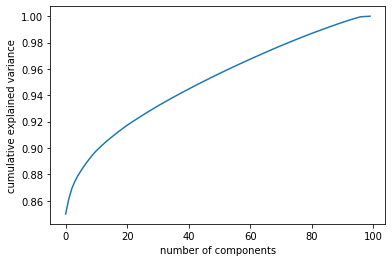

In [17]:
pca = PCA()
pca_x=pca.fit_transform(cell_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

according to above visulization, the optimum value of components to explain variance is about 20

# PCA features added to the original variables to give the model better representation of data

1)PCA features (n=100) for genes:

In [18]:
n_comp = 100
data = pd.concat([pd.DataFrame(train_features[genes]), pd.DataFrame(test_features[genes])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data))
train2 = data2[:train_features.shape[0]] 
test2 = data2[-test_features.shape[0]:]
#make dataframe of these PCA arrays for test and train
train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])
#combine these PCA features with the main features in the primary dataset
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)
print(train_features.shape)
print(test_features.shape)

(23814, 976)
(3982, 976)


PCA (n=20) for cells

In [19]:
#CELLS
n_comp = 20
data = pd.concat([pd.DataFrame(train_features[cells]), pd.DataFrame(test_features[cells])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[cells]))
train2 = data2[:train_features.shape[0]] 
test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [33]:
print(train_features.shape)
print(test_features.shape)

(23814, 996)
(3982, 996)


Deleted

In [ ]:
#remove all low-variance features with VarianceThreshold:
from sklearn.feature_selection import VarianceThreshold
var_thresh = VarianceThreshold(threshold=0.5)
data = train_features.append(test_features)
#not including 'sig_id','cp_type','cp_time','cp_dose'
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]

#add back the features that has been removed before transformation
train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

In [34]:
#add the train-labels to dataset 
train = train_features.merge(train_targets_scored, on='sig_id')
#control perturbation (ctrl_vehicle); control perturbations have no MoAs so we remove it
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)
target = train[train_targets_scored.columns]

In [35]:
#now that we removed the ctrl_vehicle, we can remove the whole variable
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [23]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_cols

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inhibitor',
 '

In [25]:
#link to multilablestratified kfold: 
#"https://github.com/trent-b/iterative-stratification/blob/master/iterstrat/ml_stratifiers.py"
import iterstrat

In [26]:
from iterstrat import MultilabelStratifiedKFold

In [ ]:
folds = train.copy()
mskf = MultilabelStratifiedKFold(n_splits=5)

#get validation and train indices and put the fold number as validation
for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

In [32]:
#sanity check 
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)

(21948, 1201)
(21948, 1202)
(3624, 995)
(21948, 207)


In [38]:
class TrainDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct

In [39]:
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [40]:
def train_fn(model, optimizer,scheduler, loss_fn, dataloader, device):
    model.train()
    epoch_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs= data['x'].to(device) 
        targets= data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        scheduler.step()
    epoch_loss /= len(dataloader)
    
    return epoch_loss        

In [41]:
def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    epoch_loss_val = 0
    valid_preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device) 
        targets = data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        epoch_loss_val += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    epoch_loss_val /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    return epoch_loss_val, valid_preds    

In [42]:
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [43]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(num_features, hidden_size)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.4)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.4)
        self.dense3 = nn.Linear(hidden_size, num_targets)
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [44]:
def initialize_weights(model):
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


In [45]:
#Convert categorical variable into dummy variables.
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [46]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

997

In [47]:
# HyperParameters
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
num_fold = 5
num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1800

In [48]:
def RUN(fold, seed):
    seed_everything(seed)
    #get the dummy variables for categorical data ('cp_time','cp_dose')
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    #in every fold we make the fold number our validation and the rest for training
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    #make data loader 
    train_dataset = TrainDataset(x_train, y_train)
    valid_dataset = TrainDataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    #initilize the model
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    ) 
    model.apply(initialize_weights)
    model.to(DEVICE)
    #initilize optimizer and cyclic schedular and since we don 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))  
    loss_fn = nn.BCEWithLogitsLoss()
    #make an empy target based on the output size for train data
    target_ = np.zeros((len(train), len(target_cols)))
    best_loss = np.inf 
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"Fold: {fold}, Epoch: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"Fold: {fold}, Epoch: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            #save the validation data predicted values
            target_[val_idx] = valid_preds 
            #save the best predictions for validation data
            torch.save(model.state_dict(), f"Fold{fold}_.pth")

    #inference
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.load_state_dict(torch.load(f"Fold{fold}_.pth"))
    model.to(DEVICE)
    predictions = inference_fn(model, testloader, DEVICE)
    return target_, predictions                         

In [49]:
def kfold_training(num_fold, seed):
    target = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    for fold in range(num_fold):
      #run the training validation and inference for every fold
        target_, pred  = RUN(fold, seed) 
        #we will use the mean value of all folds inference for prediction
        predictions += pred / num_fold
        #for validation we will use the predicted value for best loss
        target += target_
        
    return target, predictions

In [50]:
target2, predictions2 = kfold_training(num_fold,seed=2)
train[target_cols] = target2
test[target_cols] = predictions2

Fold: 0, Epoch: 0, train_loss: 0.5211988493692183
Fold: 0, Epoch: 0, valid_loss: 0.021259979477950504
Fold: 0, Epoch: 1, train_loss: 0.021508109404880932
Fold: 0, Epoch: 1, valid_loss: 0.019046979158052375
Fold: 0, Epoch: 2, train_loss: 0.021113078784791454
Fold: 0, Epoch: 2, valid_loss: 0.019700124194579467
Fold: 0, Epoch: 3, train_loss: 0.01913517199969594
Fold: 0, Epoch: 3, valid_loss: 0.018069404629724367
Fold: 0, Epoch: 4, train_loss: 0.018269851824025744
Fold: 0, Epoch: 4, valid_loss: 0.01718283894338778
Fold: 0, Epoch: 5, train_loss: 0.0177567138782014
Fold: 0, Epoch: 5, valid_loss: 0.01702781825193337
Fold: 0, Epoch: 6, train_loss: 0.01715407158801521
Fold: 0, Epoch: 6, valid_loss: 0.01689253377595118
Fold: 0, Epoch: 7, train_loss: 0.016858343743597685
Fold: 0, Epoch: 7, valid_loss: 0.01695745371814285
Fold: 0, Epoch: 8, train_loss: 0.016924677700128243
Fold: 0, Epoch: 8, valid_loss: 0.016536477979804787
Fold: 0, Epoch: 9, train_loss: 0.016618269259461027
Fold: 0, Epoch: 9, val

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

In [51]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], 
                                                                     on='sig_id', how='left').fillna(0)
#evaluate the 
y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values
score = 0
for i in range(len(target_cols)):
    score_col = log_loss(y_true[:, i], y_pred[:, i])
    score += score_col / target.shape[1]
    
print("CV log_loss: ", score)

CV log_loss:  0.01480537585492728


In [61]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


In [ ]:
sub.to_csv('submission.csv', index=False)